In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Flatten, Dense, Dropout, Multiply, Lambda
from tensorflow.keras.models import Model
import tensorflow as tf
import tushare as ts

In [6]:
ts.set_token('b425510f91120626ceacdcd9a36087804c9484b2555dd79beab964b2')
pro=ts.pro_api()
ticker='000002'#万科A
Vanke=ts.get_k_data(ticker,'2020-01-01','2024-01-01')
Vanke.set_index('date',inplace=True)
Vanke.index=pd.to_datetime(Vanke.index)
data=Vanke
data

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,open,close,high,low,volume,code
date,,,,,,
2020-01-02,28.89,28.65,29.69,28.60,1012130.0,000002
2020-01-03,28.80,28.14,28.90,27.87,805536.0,000002
2020-01-06,27.84,27.60,27.85,27.34,876840.0,000002
2020-01-07,27.70,27.85,28.02,27.44,577933.0,000002
2020-01-08,27.39,27.77,27.86,27.14,529996.0,000002
...,...,...,...,...,...,...
2023-12-25,10.34,10.30,10.38,10.28,273205.0,000002
2023-12-26,10.30,10.17,10.33,10.14,351023.0,000002
2023-12-27,10.17,10.17,10.25,10.09,343638.0,000002


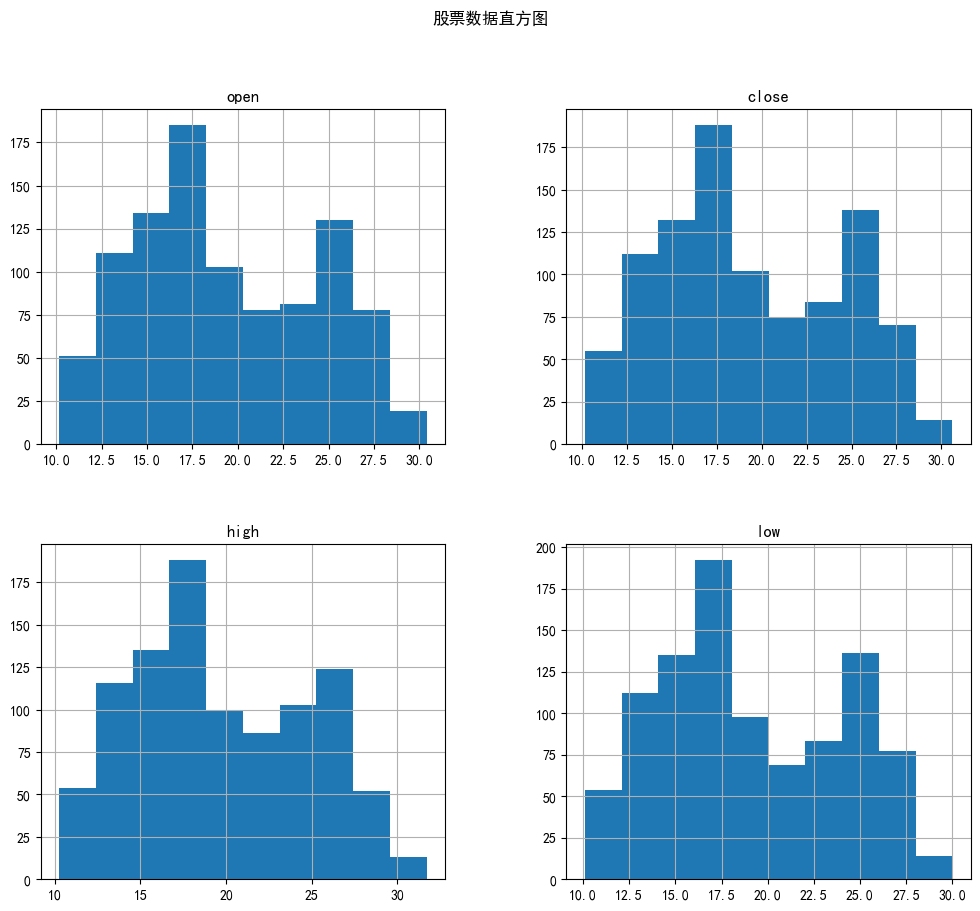

In [7]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

desc_stats = data.describe()
desc_stats
# 4. 绘制每个特征的直方图
data[['open', 'close', 'high', 'low']].hist(bins=10, figsize=(12, 10))
plt.suptitle("股票数据直方图")
plt.show()



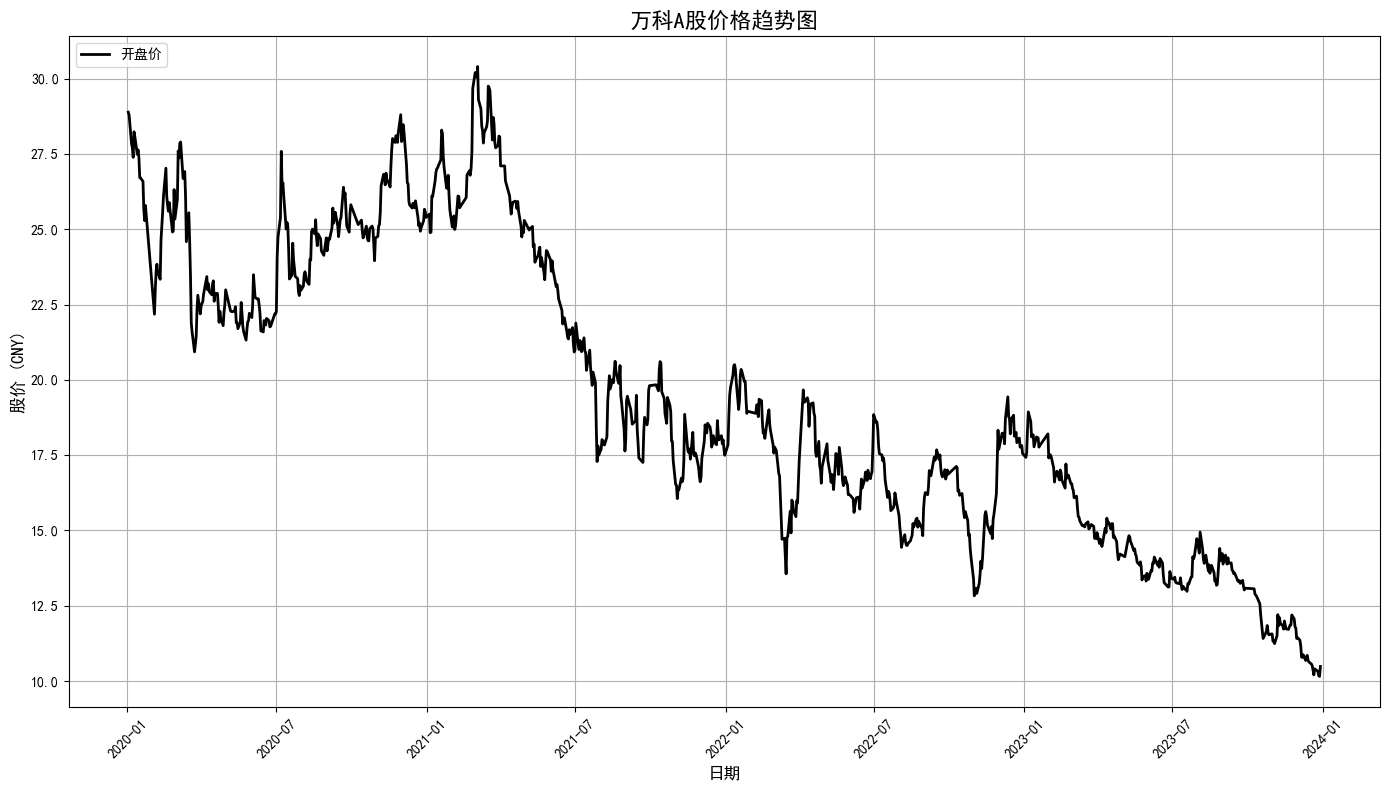

In [9]:
df=data
df = df.reset_index()
# 设置图表大小
plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['open'], label='开盘价', color='black', linestyle='-', linewidth=2)
# 添加标题和标签
plt.title('万科A股价格趋势图', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('股价 (CNY)', fontsize=12)

# 显示图例
plt.legend(loc='upper left')

# 自动旋转日期标签，避免重叠
plt.xticks(rotation=45)

# 显示图表
plt.grid(True)
plt.tight_layout()  # 自动调整布局以避免标签重叠
plt.show()

In [10]:
# 选择所需的特征
features = ['open', 'close', 'high', 'low']

# 数据归一化
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 创建时间序列输入
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 使用前8天的数据预测第9天的open, close, high, low
sequence_length = 8
X, y = create_sequences(data, features, sequence_length)

# 分割数据集（80% 训练集, 20% 测试集）
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
# 定义 TemporalBlock 类
class TemporalBlock(layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.residual = layers.Conv1D(n_outputs, kernel_size=1)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        res = self.residual(inputs)
        x = self.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = self.dropout(x)
        x += res
        return x
    
class TCNModel(tf.keras.Model):
    def __init__(self, input_shape, num_channels=[64, 64, 64], kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()

        self.input_layer = layers.InputLayer(input_shape=input_shape)
        self.blocks = []

        # 构建 Temporal Blocks
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_shape[1] if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            self.blocks.append(TemporalBlock(n_inputs=in_channels, n_outputs=out_channels, kernel_size=kernel_size,
                                             stride=1, dilation=dilation_size, padding='causal', dropout=dropout))

        # 定义 Flatten 和 Dense 层
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(dropout)
        self.dense = layers.Dense(len(features), activation='linear')  # 输出与特征数一致

    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(x)
        output = self.dense(x)
        return output


input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)
model_part1 = TCNModel(input_shape)


In [14]:
# 编译模型
model_part1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 训练模型
history = model_part1.fit(X_train, y_train, epochs=200, batch_size=64)


Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1031 - mae: 0.2370
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0165 - mae: 0.1029
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - mae: 0.0481
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - mae: 0.0417
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - mae: 0.0326
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0017 - mae: 0.0302
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - mae: 0.0360
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0018 - mae: 0.0320
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0021 - mae: 0.0346
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0026 - mae: 0.0396
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0022 - mae: 0.0360
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0270
Epoch 13/200
13/13 ━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5777e-04 - mae: 0.0171
Epoch 71/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0018 - mae: 0.0331
Epoch 72/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6848e-04 - mae: 0.0234
Epoch 73/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2343e-04 - mae: 0.0184
Epoch 74/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9326e-04 - mae: 0.0167
Epoch 75/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.3437e-04 - mae: 0.0152
Epoch 76/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8564e-04 - mae: 0.0158
Epoch 77/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8224e-04 - mae: 0.0157
Epoch 78/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5265e-04 - mae: 0.0226
Epoch 79/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0011 - mae: 0.0258
Epoch 80/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.0853e-04 - mae: 0.0204
Epoch 81/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.6865e-04 - m

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4817e-04 - mae: 0.0243
Epoch 139/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0210e-04 - mae: 0.0237
Epoch 140/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3460e-04 - mae: 0.0199
Epoch 141/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4538e-04 - mae: 0.0179
Epoch 142/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4384e-04 - mae: 0.0189
Epoch 143/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2459e-04 - mae: 0.0147
Epoch 144/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.8795e-04 - mae: 0.0154
Epoch 145/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.7366e-04 - mae: 0.0158
Epoch 146/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.7808e-04 - mae: 0.0160
Epoch 147/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.1194e-04 - mae: 0.0152
Epoch 148/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7293e-04 - mae: 0.0174
Epoch 149/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


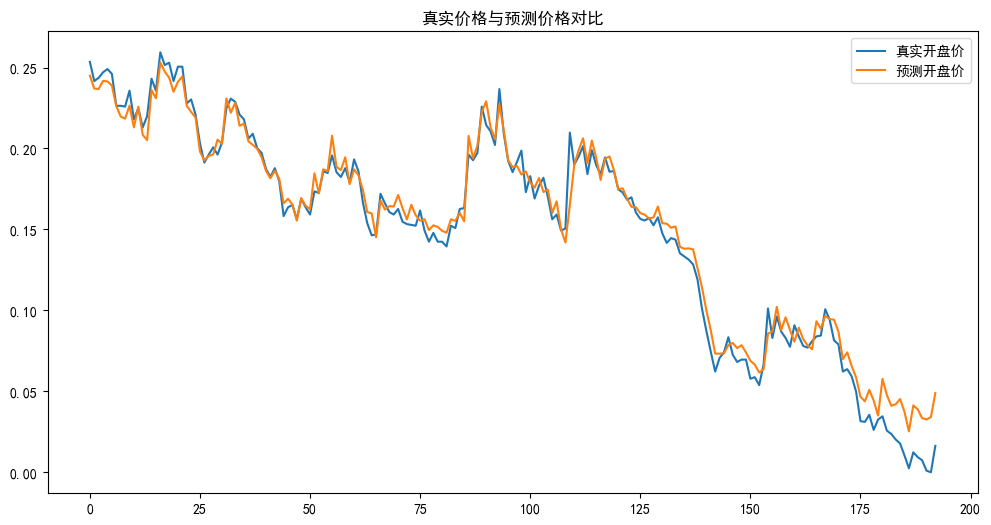

In [16]:
# 模型预测
y_pred = model_part1.predict(X_test)

# # 反归一化预测值和真实值
# y_pred_rescaled = scaler.inverse_transform(y_pred)
# y_test_rescaled = scaler.inverse_transform(y_test)

# 显示预测结果
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test[:, 0], label='真实开盘价')
plt.plot(y_pred[:, 0], label='预测开盘价')
plt.title('真实价格与预测价格对比')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 计算MAE、RMSE、MAPE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算绝对误差和误差分布
absolute_errors = np.abs(y_test - y_pred)
mean_absolute_error_by_feature = np.mean(absolute_errors, axis=0)

# 打印每个特征的平均绝对误差
features = ['Open', 'Close', 'High', 'Low']  # 对应的特征列
for i, feature in enumerate(features):
    print(f"Mean Absolute Error for {feature}: {mean_absolute_error_by_feature[i]:.4f}")



Mean Absolute Error (MAE): 0.0157
Root Mean Squared Error (RMSE): 0.0204
Mean Absolute Error for Open: 0.0074
Mean Absolute Error for Close: 0.0183
Mean Absolute Error for High: 0.0187
Mean Absolute Error for Low: 0.0182


C:\Users\jc\AppData\Local\Temp\ipykernel_10768\2415161504.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


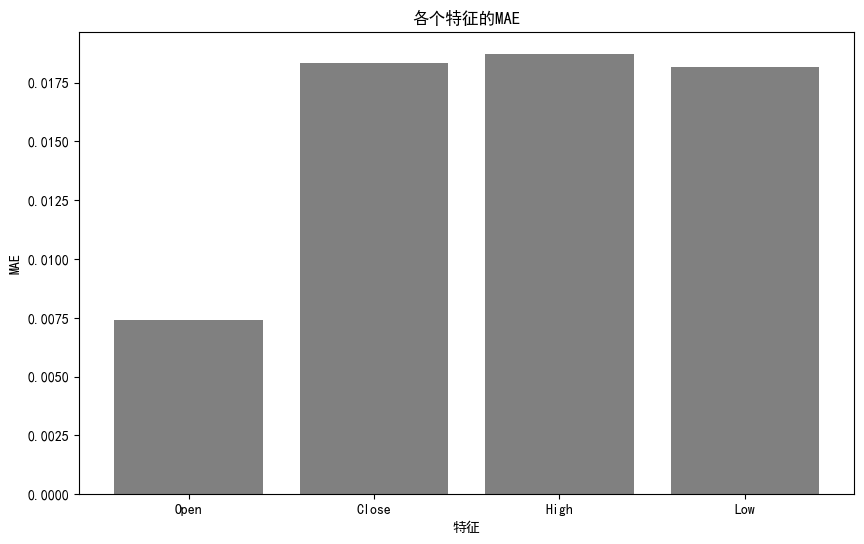

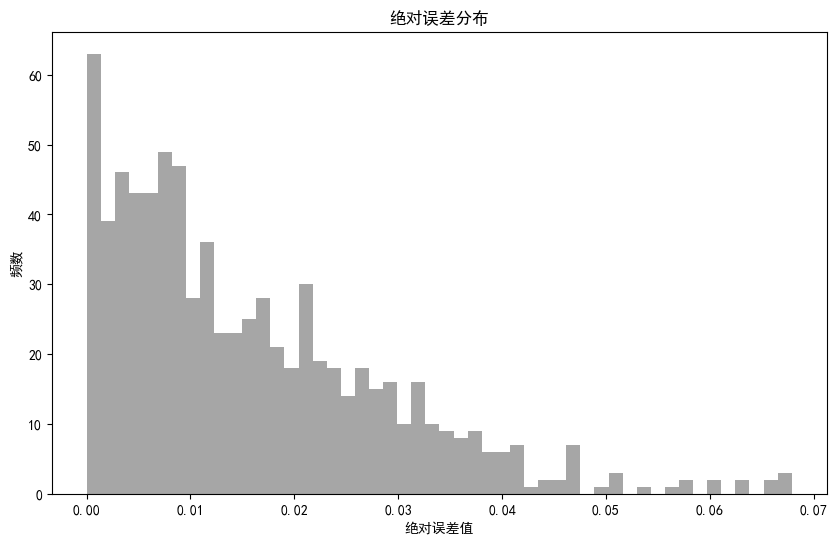

In [21]:
# 2. 绘制每个特征的平均绝对误差条形图
plt.figure(figsize=(10, 6))
plt.bar(features, mean_absolute_error_by_feature, color='grey')
plt.title('各个特征的MAE')
plt.xlabel('特征')
plt.ylabel('MAE')
plt.show()

# 3. 绘制误差的分布图（直方图）
plt.figure(figsize=(10, 6))
plt.hist(absolute_errors.flatten(), bins=50, color='grey', alpha=0.7)
plt.title('绝对误差分布')
plt.xlabel('绝对误差值')
plt.ylabel('频数')
plt.show()

In [2]:
ts.set_token('b425510f91120626ceacdcd9a36087804c9484b2555dd79beab964b2')
pro=ts.pro_api()
ticker='000002'#万科A
Vanke2=ts.get_k_data(ticker,'2022-01-01','2024-10-01')
Vanke2.set_index('date',inplace=True)
Vanke2.index=pd.to_datetime(Vanke2.index)
data2=Vanke2
data2

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,open,close,high,low,volume,code
date,,,,,,
2022-01-04,17.846,18.846,19.006,17.716,1947202.0,000002
2022-01-05,18.786,19.526,19.966,18.716,1930458.0,000002
2022-01-06,19.476,19.406,20.016,19.146,1380274.0,000002
2022-01-07,19.736,20.246,20.816,19.706,2262768.0,000002
2022-01-10,20.156,20.516,21.016,19.916,1527797.0,000002
...,...,...,...,...,...,...
2024-09-24,7.070,7.120,7.170,6.810,3244215.0,000002
2024-09-25,7.140,7.310,7.680,7.110,3935250.0,000002
2024-09-26,7.220,8.040,8.040,7.220,5278410.0,000002


In [3]:
# 选择所需的特征
features = ['open', 'close', 'high', 'low']
# 数据归一化
scaler = MinMaxScaler()
data2[features] = scaler.fit_transform(data2[features])
# 创建时间序列输入
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 使用前8天的数据预测第9天的open, close, high, low
sequence_length = 8
X2, y2 = create_sequences(data2, features, sequence_length)

# 分割数据集（80% 训练集, 20% 测试集）
split_index = int(len(X2) * 0.8)
X2_train, X2_test = X2[:split_index], X2[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 定义 TemporalBlock 类
class TemporalBlock(layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        
        self.conv1 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.relu = layers.ReLU()
        self.conv2 = layers.Conv1D(n_outputs, kernel_size, strides=stride, dilation_rate=dilation, padding=padding)
        self.residual = layers.Conv1D(n_outputs, kernel_size=1)
        self.dropout = layers.Dropout(dropout)

    def call(self, inputs):
        res = self.residual(inputs)
        x = self.relu(self.conv1(inputs))
        x = self.conv2(x)
        x = self.dropout(x)
        x += res
        return x

# 定义 TCNModel 类
class TCNModel(tf.keras.Model):
    def __init__(self, input_shape, num_channels=[64, 64, 64], kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()

        self.input_layer = layers.InputLayer(input_shape=input_shape)
        self.blocks = []

        # 构建 Temporal Blocks
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_shape[1] if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = 'causal'  # Causal padding for TCN
            self.blocks.append(TemporalBlock(n_inputs=in_channels, n_outputs=out_channels, kernel_size=kernel_size,
                                             stride=1, dilation=dilation_size, padding=padding, dropout=dropout))

        # 定义 Flatten 和 Dense 层
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(dropout)
        self.dense = layers.Dense(len(features), activation='linear')
    def call(self, inputs):
        x = inputs
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.dropout(x)
        output = self.dense(x)
        return output


input_shape = (X2_train.shape[1], X2_train.shape[2])  # (sequence_length, num_features)
model_part2 = TCNModel(input_shape)

D:\anaconda\conda\lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
# 编译模型
model_part2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 训练模型
history = model_part2.fit(X2_train, y2_train, epochs=200, batch_size=64)

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1217 - mae: 0.2648
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0207 - mae: 0.1115
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - mae: 0.0650
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049 - mae: 0.0509
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - mae: 0.0416
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - mae: 0.0374
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0026 - mae: 0.0365
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - mae: 0.0365
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0027 - mae: 0.0387
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0024 - mae: 0.0367
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0022 - mae: 0.0358
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.0309
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1628e-04 - mae: 0.0145
Epoch 72/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.1315e-04 - mae: 0.0141
Epoch 73/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7868e-04 - mae: 0.0172
Epoch 74/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.4436e-04 - mae: 0.0169
Epoch 75/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4815e-04 - mae: 0.0181
Epoch 76/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9055e-04 - mae: 0.0183
Epoch 77/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.3390e-04 - mae: 0.0155
Epoch 78/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.8635e-04 - mae: 0.0150
Epoch 79/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2693e-04 - mae: 0.0150
Epoch 80/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.5507e-04 - mae: 0.0149
Epoch 81/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0255e-04 - mae: 0.0174
Epoch 82/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8996e-04 - mae: 0.0165
Epoch

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9364e-04 - mae: 0.0205
Epoch 141/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.0138e-04 - mae: 0.0197
Epoch 142/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.2340e-04 - mae: 0.0145
Epoch 143/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.1079e-04 - mae: 0.0140
Epoch 144/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6492e-04 - mae: 0.0138
Epoch 145/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.6720e-04 - mae: 0.0139
Epoch 146/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7643e-04 - mae: 0.0135
Epoch 147/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0661e-04 - mae: 0.0136
Epoch 148/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0988e-04 - mae: 0.0140
Epoch 149/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5759e-04 - mae: 0.0172
Epoch 150/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.2747e-04 - mae: 0.0152
Epoch 151/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8032e-04 - mae: 0

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


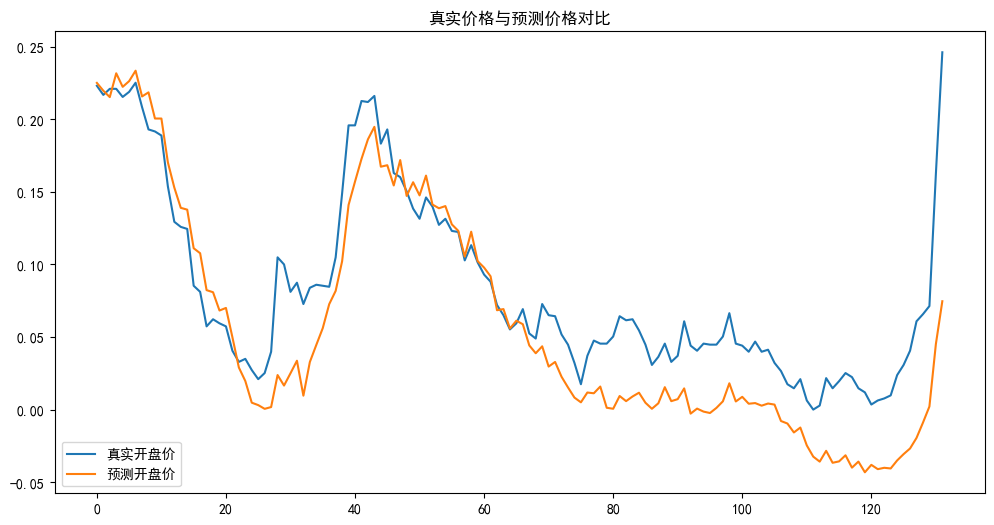

In [7]:
# 模型预测
y2_pred = model_part2.predict(X2_test)
# 显示预测结果
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y2_test[:, 0], label='真实开盘价')
plt.plot(y2_pred[:, 0], label='预测开盘价')
plt.title('真实价格与预测价格对比')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 计算MAE、RMSE、MAPE
mae = mean_absolute_error(y2_test, y2_pred)
rmse = np.sqrt(mean_squared_error(y2_test, y2_pred))
mape = np.mean(np.abs((y2_test - y2_pred) / y2_test)) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 计算绝对误差和误差分布
absolute_errors = np.abs(y2_test - y2_pred)
mean_absolute_error_by_feature = np.mean(absolute_errors, axis=0)

# 打印每个特征的平均绝对误差
features = ['Open', 'Close', 'High', 'Low']  # 对应的特征列
for i, feature in enumerate(features):
    print(f"Mean Absolute Error for {feature}: {mean_absolute_error_by_feature[i]:.4f}")

Mean Absolute Error (MAE): 0.0128
Root Mean Squared Error (RMSE): 0.0187
Mean Absolute Error for Open: 0.0093
Mean Absolute Error for Close: 0.0181
Mean Absolute Error for High: 0.0130
Mean Absolute Error for Low: 0.0106


C:\Users\jc\AppData\Local\Temp\ipykernel_10768\4257244365.py:6: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y2_test - y2_pred) / y2_test)) * 100


In [8]:
# 设置 Token
ts.set_token('b425510f91120626ceacdcd9a36087804c9484b2555dd79beab964b2')
pro = ts.pro_api()
# 获取数据
ticker = '000002'  # 万科A
Vanke3 = ts.get_k_data(ticker, '2020-01-01', '2022-01-01')
Vanke3.set_index('date', inplace=True)
Vanke3.index = pd.to_datetime(Vanke3.index)
data3 = Vanke3
# 选择所需的特征
features = ['open', 'close', 'high', 'low']

# 数据归一化
scaler = MinMaxScaler()
data3[features] = scaler.fit_transform(data3[features])
# 创建时间序列输入
def create_sequences(data, feature_columns, sequence_length=8):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[feature_columns].iloc[i:i+sequence_length].values
        label = data[feature_columns].iloc[i+sequence_length].values
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

# 使用前8天的数据预测第9天的open, close, high, low
sequence_length = 8
X3, y3 = create_sequences(data3, features, sequence_length)



本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
D:\anaconda\conda\lib\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


In [11]:
# 分割数据集（80% 训练集, 20% 验证集）
split_index = int(len(X3) * 0.8)
X3_train, X3_val = X3[:split_index], X3[split_index:]
y3_train, y3_val = y3[:split_index], y3[split_index:]
input_shape = (X3_train.shape[1], X3_train.shape[2])
model_part3= TCNModel(input_shape)
# 编译模型
model_part3.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 训练模型
history = model_part3.fit(X3_train, y3_train, epochs=200, batch_size=64, validation_data=(X3_val, y3_val))

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - loss: 0.2740 - mae: 0.3801 - val_loss: 0.0117 - val_mae: 0.0857
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0350 - mae: 0.1498 - val_loss: 0.0092 - val_mae: 0.0777
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0336 - mae: 0.1457 - val_loss: 0.0058 - val_mae: 0.0600
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0130 - mae: 0.0888 - val_loss: 0.0064 - val_mae: 0.0642
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0086 - mae: 0.0703 - val_loss: 0.0045 - val_mae: 0.0517
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0086 - mae: 0.0690 - val_loss: 0.0041 - val_mae: 0.0500
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0063 - mae: 0.0574 - val_loss: 0.0042 - val_mae: 0.0513
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052 - mae: 0.0534 - val_loss: 0.0035 - val_mae: 0.0456
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0049 - mae:

Epoch 55/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1905e-04 - mae: 0.0222 - val_loss: 9.8653e-04 - val_mae: 0.0221
Epoch 56/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 57/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 58/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 9.6950e-04 - val_mae: 0.0221
Epoch 59/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0015 - mae: 0.0302 - val_loss: 9.7658e-04 - val_mae: 0.0222
Epoch 60/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0014 - mae: 0.0292 - val_loss: 0.0010 - val_mae: 0.0237
Epoch 61/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0011 - val_mae: 0.0244
Epoch 62/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0010 - val_mae: 0.0231
Epoch 63/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/st

Epoch 108/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.7417e-04 - mae: 0.0209 - val_loss: 0.0011 - val_mae: 0.0248
Epoch 109/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.9445e-04 - mae: 0.0199 - val_loss: 0.0011 - val_mae: 0.0242
Epoch 110/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.6209e-04 - mae: 0.0220 - val_loss: 0.0011 - val_mae: 0.0239
Epoch 111/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.5798e-04 - mae: 0.0206 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 112/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.7067e-04 - mae: 0.0229 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 113/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 8.1156e-04 - mae: 0.0210 - val_loss: 0.0011 - val_mae: 0.0245
Epoch 114/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.5211e-04 - mae: 0.0201 - val_loss: 0.0011 - val_mae: 0.0245
Epoch 115/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6482e-04 - mae: 0.0194 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 116/200
6/6 ━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.8570e-04 - mae: 0.0179 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 161/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.3047e-04 - mae: 0.0204 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 162/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.9529e-04 - mae: 0.0201 - val_loss: 0.0015 - val_mae: 0.0288
Epoch 163/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 6.4580e-04 - mae: 0.0185 - val_loss: 0.0015 - val_mae: 0.0292
Epoch 164/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.6293e-04 - mae: 0.0200 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 165/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.7826e-04 - mae: 0.0202 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 166/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 6.9508e-04 - mae: 0.0181 - val_loss: 0.0015 - val_mae: 0.0290
Epoch 167/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.7154e-04 - mae: 0.0197 - val_loss: 0.0016 - val_mae: 0.0301
Epoch 168/200
6/6 ━━━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


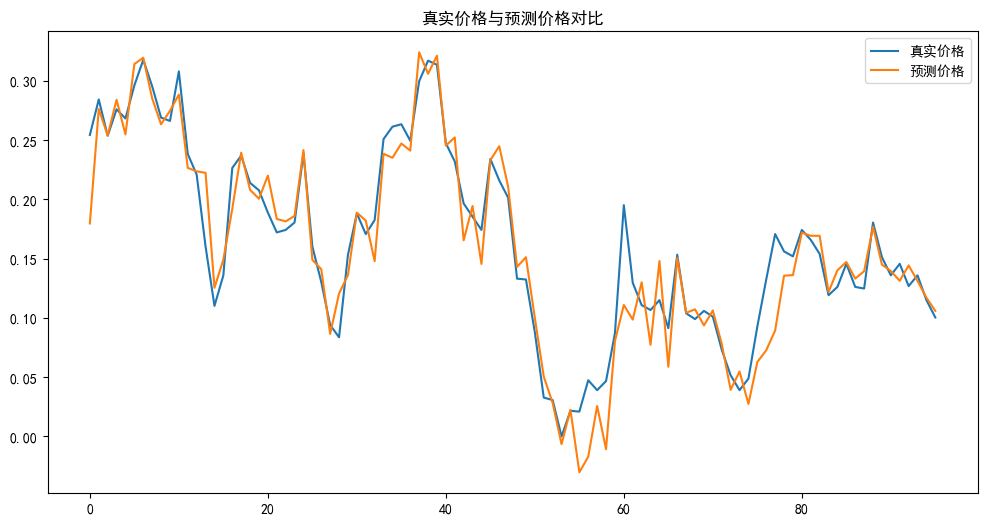

In [13]:
# 模型预测
y3_pred = model_part3.predict(X3_val)
# 显示预测结果
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y3_val[:, 0], label='真实价格')
plt.plot(y3_pred[:, 0], label='预测价格')
plt.title('真实价格与预测价格对比')
plt.legend()
plt.show()